In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import cvxpy as cp
import diffrax

from soromox.systems.tendon_actuated_pendulum import TendonActuatedPendulum

from MPC import LinearizedMPC, LinearizedMPCTest

In [2]:
num_links = 1
params = {
    "m": jnp.array([10.0]),
    "I": jnp.array([3.0]),
    "L": jnp.array([2.0]),
    "Lc": jnp.array([1.0]),
    "g": jnp.array([0.0, -9.81]),
}

pendulum = TendonActuatedPendulum(params=params)

nx = 2 * num_links
nu = 1

In [3]:
@jax.jit
def dynamics(t, x, u):
    return pendulum.forward_dynamics(t, x, (u,))

def output(x):
    return x[0]


# Jacobians using JAX autodiff
A_fun = jax.jit(jax.jacfwd(lambda x, u: dynamics(None, x, u), argnums=0))
B_fun = jax.jit(jax.jacfwd(lambda x, u: dynamics(None, x, u), argnums=1))

# equilibrium (upright)
q_eq = jnp.pi/2 * jnp.ones(num_links)
qd_eq = jnp.zeros(num_links)
x_eq = jnp.concatenate([q_eq, qd_eq])
u_eq = jnp.zeros(nu)

A_c_eq = np.asarray(A_fun(x_eq, u_eq)).reshape(nx, nx)   # continuous-time A
B_c_eq = np.asarray(B_fun(x_eq, u_eq)).reshape(nx, nu)   # continuous-time B

print("A_c_eq:\n", A_c_eq)
print("B_c_eq:\n", B_c_eq)

A_c_eq:
 [[0.         1.        ]
 [7.54615385 0.        ]]
B_c_eq:
 [[0.        ]
 [0.07692308]]


In [4]:
# ---------------------------------------------------------
# 2. DISCRETIZE LINEAR SYSTEM
# ---------------------------------------------------------
dt = 0.05
A_d_eq = np.eye(nx) + dt * A_c_eq
B_d_eq = dt * B_c_eq

In [5]:
# ---------------------------------------------------------
# 3. BUILD CVXPY LINEAR MPC PROBLEM (QP)
# ---------------------------------------------------------
N = 50

Q = np.diag([50.0]*num_links + [1.0]*num_links)
R = np.diag([0.001]*nu)

u_max = 200.0

# Decision variables
dx = cp.Variable((N+1, nx), 'dx')
du = cp.Variable((N, nu), 'du')

# Parameters (updated every MPC step)
x0 = cp.Parameter(nx, 'x0')
x_hat = cp.Parameter((N+1, nx), 'x_hat')
u_hat = cp.Parameter((N, nu), 'u_hat')
A_d = cp.Parameter((N, nx, nx), 'A_d')
B_d = cp.Parameter((N, nx, nu), 'B_d')
x_ref = cp.Parameter(nx, 'x_ref')

cost = 0
constraints = [x_hat[0, :] + dx[0, :] == x0]

for i in range(N):
    cost += cp.quad_form(x_hat[i, :] + dx[i, :] - x_ref, Q)
    cost += cp.quad_form(u_hat[i, :] + du[i, :], R)
    constraints += [dx[i+1, :] == A_d[i, :, :] @ dx[i, :] + B_d[i, :, :] @ du[i, :]]
    constraints += [cp.abs(u_hat[i, :] + du[i, :]) <= u_max]

# terminal cost
cost += cp.quad_form(x_hat[N, :] + dx[N, :] - x_ref, Q)

# Problem definition
prob = cp.Problem(cp.Minimize(cost), constraints)

In [6]:
controller = LinearizedMPC(dynamics, N, dt, nx, nu, Q, R)

In [7]:
# ---------------------------------------------------------
# 4. SIMULATION USING JAX REAL DYNAMICS
# ---------------------------------------------------------
@jax.jit
def simulate_step(x, u):
    sol = diffrax.diffeqsolve(terms=diffrax.ODETerm(dynamics), solver=diffrax.Tsit5(), t0=0.0, t1=dt, dt0=1e-4, y0=x, args=u, saveat=diffrax.SaveAt(ts=[dt]))
    return sol.ys

T_sim = 5.0
steps = int(T_sim / dt)

x = np.array([-np.pi / 2, 0.0])   # very far from upright
x_ref.value = np.asarray(x_eq)
controller.x_ref.value = np.asarray(x_eq)

x_star = np.tile(x, (N+1, 1))
u_star = np.zeros((N, nu))
A_d_star = np.zeros((N, nx, nx))
B_d_star = np.zeros((N, nx, nu))
controller.x_bar = x_star
controller.u_bar = u_star

trajectory_x = [x]
trajectory_u = []
cost_mpc_sol = []
for t in range(steps):

    # x_star[0, :] = trajectory_x[-1]
    for i in range(N):
        A_d_star[i, :, :] = np.eye(nx) + dt * np.asarray(A_fun(x_star[i, :], u_star[i, :])).reshape(nx, nx)
        B_d_star[i, :, :] = dt * np.asarray(B_fun(x_star[i, :], u_star[i, :])).reshape((nx, nu))

    # update parameter
    x0.value = x
    x_hat.value = x_star
    u_hat.value = u_star
    A_d.value = A_d_star
    B_d.value = B_d_star
    dx.value = np.zeros(dx.shape)
    du.value = np.zeros(du.shape)

    # controller.x0.value = x
    # controller.x_hat.value = x_star
    # controller.u_hat.value = u_star
    # controller.A.value = A_d_star
    # controller.B.value = B_d_star
    # controller.dx.value = np.zeros(dx.shape)
    # controller.du.value = np.zeros(du.shape)  

    # solve MPC
    prob.solve(solver=cp.OSQP)
    cost_mpc_sol.append(prob.value)
    x_mpc_sol = x_hat.value + dx.value
    u_mpc_sol = u_hat.value + du.value

    controller.solve_ocp(x, np.asarray(x_eq))
    # print(np.all(controller.A_d.value == A_d.value), np.all(controller.B_d.value == B_d.value))
    # print(np.all(controller.x_hat.value == x_hat.value), np.all(controller.u_hat.value == u_hat.value))
    assert np.all(controller.dx.value == dx.value), controller.du.value - du.value
    # print(controller.du.value - du.value)

    # real JAX dynamics simulation
    u_apply = u_mpc_sol[0, :]     # first control input
    x = np.asarray(simulate_step(x, u_apply)).squeeze()
    trajectory_x.append(x)
    trajectory_u.append(u_apply)

    u_star = np.vstack([u_mpc_sol[1:, :], np.zeros((1, nu))])
    x_star = np.vstack([x_mpc_sol[1:, :], x_mpc_sol[-1, :]])


trajectory_x = np.array(trajectory_x).reshape(steps+1, nx, 1)
trajectory_u = np.array(trajectory_u).reshape(steps, nu, 1)
trajectory_cost = np.sum(trajectory_x.mT @ Q @ trajectory_x, axis=0) + np.sum(trajectory_u.mT @ R @ trajectory_u)

print("Finished CVXPY MPC simulation.")
print("Trajectory Cost: ", trajectory_cost * dt)

/home/lars/Code/SoRoMPC/.venv/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain_utils.py:41: UserWarning: The problem has an expression with dimension greater than 2. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


Finished CVXPY MPC simulation.
Trajectory Cost:  [[853.65562181]]


In [17]:
print(str(prob.constraints[0]) == str(controller.ocp.constraints[0]))

True


In [ ]:
print(A_d_star - controller.A.value)

[[[ 0.00000000e+00  0.00000000e+00]
  [ 1.68731756e-05  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 2.43191566e-02  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 7.45778818e-02  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 1.16336723e-01  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 1.73499002e-01  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 2.18797713e-01  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 2.47046264e-01  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 2.42023085e-01  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 2.09404135e-01  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 1.47269071e-01  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 7.34643404e-02  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 1.40261936e-02  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [-5.30521917e-03  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  

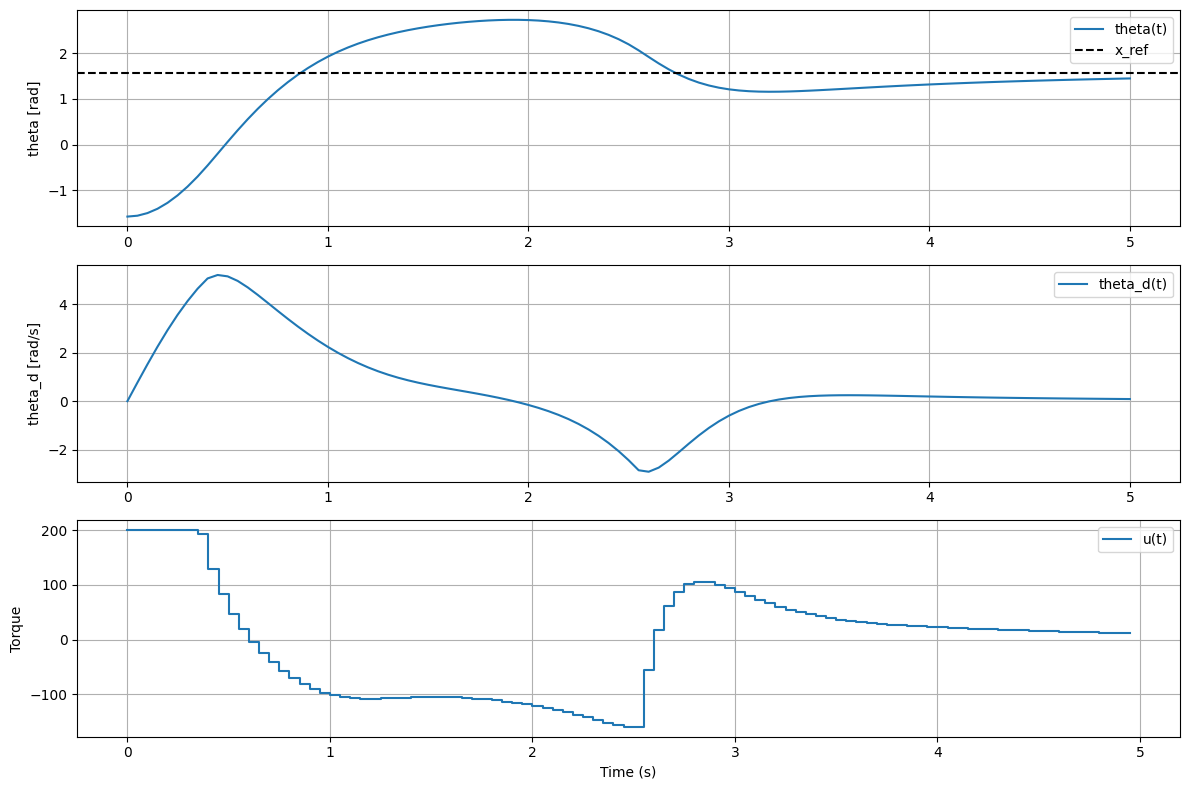

In [8]:
import matplotlib.pyplot as plt

trajectory_x = np.array(trajectory_x)
trajectory_u = np.array(trajectory_u)
time = np.arange(trajectory_x.shape[0]) * dt

plt.figure(figsize=(12,8))

# -----------------------------
# Plot Theta
# -----------------------------
plt.subplot(3,1,1)
plt.plot(time, trajectory_x[:, 0].squeeze(), label="theta(t)")
plt.axhline(x_ref.value[0], color="k", linestyle="--", label="x_ref")
plt.ylabel("theta [rad]")
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Theta_dot
# -----------------------------
plt.subplot(3,1,2)
plt.plot(time, trajectory_x[:, 1].squeeze(), label="theta_d(t)")
plt.ylabel("theta_d [rad/s]")
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Control Input
# -----------------------------
plt.subplot(3,1,3)
plt.step(time[:-1], trajectory_u[:, 0].squeeze(), where="post", label="u(t)")
plt.ylabel("Torque")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
